In [1]:
%load_ext autoreload
%autoreload 2

from optimizers.perturbed_gd import PerturbedGD
from optimizers.cubic_reg import StochasticCubicRegularizedNewton
from models.nn import Net, SimpleNet

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.nn import MSELoss
import torch.nn.functional as F
import torch.autograd as autograd
from copy import deepcopy

from matplotlib import pyplot as plt


## Load the dataset

In [2]:
grad_batch_size = 64
hess_batch_size = 64

dataset_train = MNIST('data/',
                      train=True,
                      download=True,
                      transform=Compose([
                            ToTensor(),
                            Normalize((0.1307,), (0.3081,))
                            ]))
dataset_test = MNIST('data/',
          train=False,
          download=True,
          transform=Compose([ToTensor(),
                             Normalize((0.1307,), (0.3081,))
                             ]))

batch_size_test = len(dataset_test)

print("Train dataset size:",len(dataset_train))
print("Test dataset size:",len(dataset_test))
train_loader_grad = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=grad_batch_size, shuffle=True)

train_loader_hess = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=hess_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
  batch_size=batch_size_test, shuffle=True)

Train dataset size: 60000
Test dataset size: 10000


## Perturbed Gradient Descent

In [7]:

model_pgd = Net()
loss_fn_pgd = F.nll_loss

optimizer_pgd = PerturbedGD(model_pgd.parameters(),
                        l=100,
                        rho=10,
                        epsilon=1e-4,
                        c=.5,
                        delta=.1,
                        delta_f=10,
                        d=2)
iter_grad = iter(train_loader_grad)
test_data, test_labels = next(iter(test_loader))
batch_idx = 0
losses_pgd = []
while True:
    if batch_idx == 40:
        break
        
    print("At batch:",batch_idx)
    losses_pgd.append(loss_fn_pgd(model_pgd(test_data), test_labels))
    if optimizer_pgd._is_done:
        print("Optimizer has hit early stopping condition")
        break
    optimizer_pgd.zero_grad()
    
    data_for_grad = next(iter_grad, None)
    
    if data_for_grad is None: 
        print("Exhausted training data -- finished optimization")
        break
    features_g, labels_g = data_for_grad
    
    loss_g = loss_fn_pgd(model_pgd(features_g), labels_g)
    loss_g.backward()
    
    optimizer_pgd.step()
    
    batch_idx += 1


At batch: 0
At batch: 1
At batch: 2
At batch: 3
At batch: 4
At batch: 5
At batch: 6
At batch: 7
At batch: 8
At batch: 9
At batch: 10
At batch: 11
At batch: 12
At batch: 13
At batch: 14
At batch: 15
At batch: 16
At batch: 17
At batch: 18
At batch: 19
At batch: 20
At batch: 21
At batch: 22
At batch: 23
At batch: 24
At batch: 25
At batch: 26
At batch: 27
At batch: 28
At batch: 29
At batch: 30
At batch: 31
At batch: 32
At batch: 33
At batch: 34
At batch: 35
At batch: 36
At batch: 37
At batch: 38
At batch: 39


## Stochastic Cubic Regularized Newton's method

In [4]:

model_scrn = Net()
loss_fn_scrn = F.nll_loss

optimizer = StochasticCubicRegularizedNewton(model_scrn.parameters(),
                                             l=100,
                                             rho=100,
                                             epsilon=1e-4,
                                             c_prime=1)


iter_grad = iter(train_loader_grad)
iter_hess = iter(train_loader_hess)
test_data, test_labels = next(iter(test_loader))
batch_idx = 0
losses_scrn = []
while True:
    print("At batch:",batch_idx)
    losses_scrn.append(loss_fn_scrn(model_scrn(test_data), test_labels))
    if optimizer._is_done:
        break
    optimizer.zero_grad()
    
    data_for_grad = next(iter_grad, None)
    data_for_hess = next(iter_hess, None)
    
    if data_for_grad is None or data_for_hess is None:
        print("Exhausted training data -- finished optimization")
        break
    features_g, labels_g = data_for_grad
    features_h, labels_h = data_for_hess
    
    loss_h = loss_fn_scrn(model_scrn(features_h), labels_h)
    
    flattened_grad_h = []
    for p in model_scrn.parameters():
        flattened_grad_h.append(autograd.grad(loss_h, p, create_graph=True)[0].view(-1))
    flattened_grad_h = torch.cat(flattened_grad_h)
    
    loss_g = loss_fn_scrn(model_scrn(features_g), labels_g)
    loss_g.backward()
    
    optimizer.step(flattened_grad_h)
    
    batch_idx += 1
    

Train dataset size: 60000
Test dataset size: 10000
At batch: 0
At batch: 1
At batch: 2
At batch: 3
At batch: 4
At batch: 5
At batch: 6
At batch: 7
At batch: 8
At batch: 9
At batch: 10
At batch: 11
At batch: 12
At batch: 13
At batch: 14
At batch: 15
At batch: 16
At batch: 17
At batch: 18
At batch: 19
At batch: 20
At batch: 21
At batch: 22
At batch: 23
At batch: 24


KeyboardInterrupt: 

Text(0.5, 1.0, 'Batch size for gradient=64 and for hessian=64')

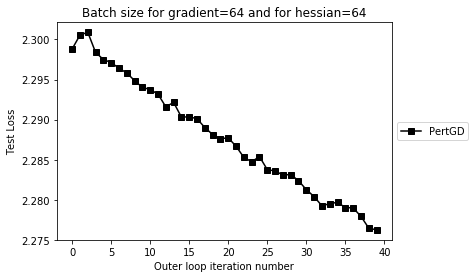

In [8]:

# plt.plot(range(len(losses_scrn)), losses_scrn, 'ks-', label='StochasticCubic')
plt.plot(range(len(losses_pgd)), losses_pgd, 'ks-', label='PertGD')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Outer loop iteration number")
plt.ylabel("Test Loss")
plt.title("Batch size for gradient=%d and for hessian=%d"%(grad_batch_size, hess_batch_size))

